In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# adapted from http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/
# and https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, fc='none', ec=[0,0,0], a=1, lw=2):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)
    return ellip

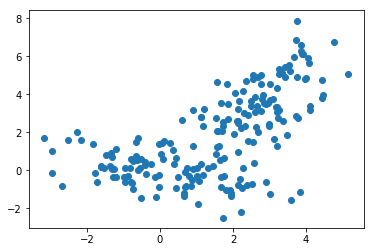

In [3]:
np.random.seed(285714)
mean1 = [3, 4]
mean2 = [0, 0]
cov1 = [[1, 0.5], [0.5, 2]]
cov2 = [[3, -1], [-1, 1]]
cluster1 = np.random.multivariate_normal(mean1, cov1, 100)
cluster2 = np.random.multivariate_normal(mean2, cov2, 100)

X = np.concatenate([cluster1, cluster2], axis=0)
plt.scatter(X[:, 0], X[:, 1])

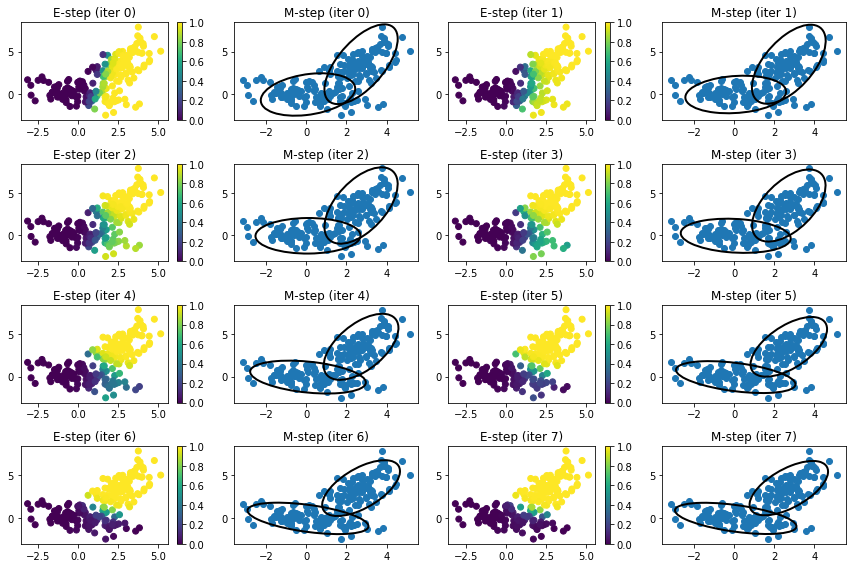

In [4]:
k = 2

# initialization
mu = np.asarray([[-2, 0], [4, -1]], dtype=np.float)
sigma = np.asarray([[[1, 0], [0, 1]], [[1, 0], [0, 1]]], dtype=np.float)

n_iterations = 8
n_rows, n_cols = np.ceil(0.5*n_iterations), 4

fig = plt.figure(figsize=(12, n_iterations))
for i in range(n_iterations):
    # E-step
    Z = np.empty((X.shape[0], k))
    for j in range(k):
        Z[:, j] = (1/np.linalg.det(sigma[j])) * np.exp(-0.5 * ((X-mu[j]).dot(np.linalg.inv(sigma[j])) * (X-mu[j])).sum(axis=1))
    Z /= Z.sum(axis=1, keepdims=True)

    ax = fig.add_subplot(n_rows, n_cols, i*2+1)
    plot = ax.scatter(X[:, 0], X[:, 1], c=Z[:, 1], vmin=0, vmax=1, cmap='viridis')
    plt.colorbar(plot, ax=ax)
    ax.set_title('E-step (iter %d)'%i)
    
    # M-step
    for j in range(k):
        mu[j]    = Z[:, j].dot(X) / Z[:, j].sum()
        sigma[j] = ((X-mu[j]).T.dot(np.diag(Z[:, j])).dot(X-mu[j])) / Z[:, j].sum()
    
    ax = fig.add_subplot(n_rows, n_cols, i*2+2)
    ax.scatter(X[:, 0], X[:, 1])
    for j in range(k):
        plot_cov_ellipse(sigma[j], mu[j])
    ax.set_title('M-step (iter %d)'%i)

plt.tight_layout()
plt.show()